# Titanic: Machine Learning from Disaster

The Titanic competition on Kaggle can be found [here](https://www.kaggle.com/c/titanic) and is one of the starter competitions to practice basic machine learning techniques.  The objective is to utilize a passenger manifest dataset to predict survival.

In this notebook I will document my thoughts as I perform the following steps:

1. Conduct exploratory data analysis
2. Prepare features for modeling
3. Build, tune and evaluate a model

In [1]:
# Import some libraries for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# View plots inline
%matplotlib inline

In [2]:
# Read in training and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# Add new columns that indicates the source of the data
train_df['Source'] = 'Training'
test_df['Source'] = 'Test'

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Source       891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [4]:
# View training data header
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Source
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Training
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Training
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Training
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Training
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Training


In [5]:
# Combine the training and test data to view statistics and perform data cleaning
combined = [train_df, test_df]
combined_df = pd.concat(combined)

In [6]:
# View data types for combined dataset
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Source       1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [7]:
# Numeric statistics for combined dataset
combined_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [8]:
# Categorical statistics for combined dataset
combined_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked,Source
count,1309,1309,1309,295,1307,1309
unique,1307,2,929,186,3,2
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S,Training
freq,2,843,11,6,914,891


#### Initial observations

* 1309 total records: 891 records in the training set and 418 in the test set.
* PassengerId is unique for every passenger and will be dropped.
* Survived is the outcome that we are trying to predict and is only present in the training set.
* 38% of the passengers in the training set survived.
* Pclass is an ordinal categorical variable for the ticket class: 1 = First, 2 = Second, 3 = Third.
* Name on its own may not offer much predictive power due to its uniqueness.  However, Title could be extracted from the name and the format appears to be consistent as "Last Name, Title First Name" so the title will be extracted and explored further.
* Name for married females appears to follow the format "Last Name, Title First Name of spouse (First Name)" so this format could be utilized to identified married passengers.
* Sex has 2 unique values with the majority of the passengers being male.
* Age has 263 missing values and will be replaced after data analysis.
* Fare has 1 missing value and will be replaced after data analysis.
* Ticket has no missing values and 929 unique values so may not offer much predictive power.  However, similar to Name there may be a part of the Ticket that could be extracted and explored further.
* Cabin has 1014 missing values.  It is assumed not all tickets included a cabin so this may be the explanation for the missing values.  Cabin may also be related to Pclass so this will be explored further.
* Embarked only has 2 missing values and there are only 3 ports with the majority of the passengers from the Southampton port.  The missing values will be replaced.

## Exploratory data analysis

In [9]:
# Survived palette
pal = {1: 'green', 0: 'red'}

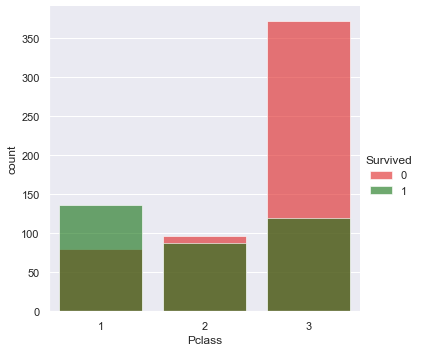

In [10]:
# Pclass Survived Count plot
sns.catplot(x='Pclass', hue='Survived', palette=pal, data=train_df, kind='count', 
               dodge=False, alpha=0.6);

### This catplot will be used frequently with dodge=False.  This puts the bars on top of each other and by setting alpha to .6 you can still see the height of the shorter bar.  This visual allows you to quickly identify when a particular category had a higher survival rate (> 50%) since light green will be visible.

Pclass is a proxy for socio-economic status:

- 1st = Upper
- 2nd = Middle
- 3rd = Lower

Survival chance is higher for upper class passengers.

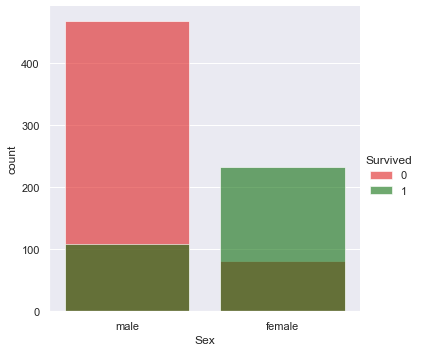

In [11]:
# Sex and Survived Count plot
sns.catplot(x='Sex', hue='Survived', palette=pal, data=train_df, kind='count', 
               dodge=False, alpha=0.6);

Survival chance is higher for females.

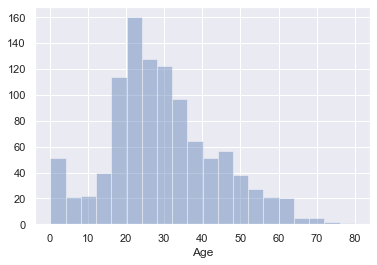

In [12]:
# Age Histogram
sns.distplot(combined_df['Age'].dropna(), bins=20, kde=False);

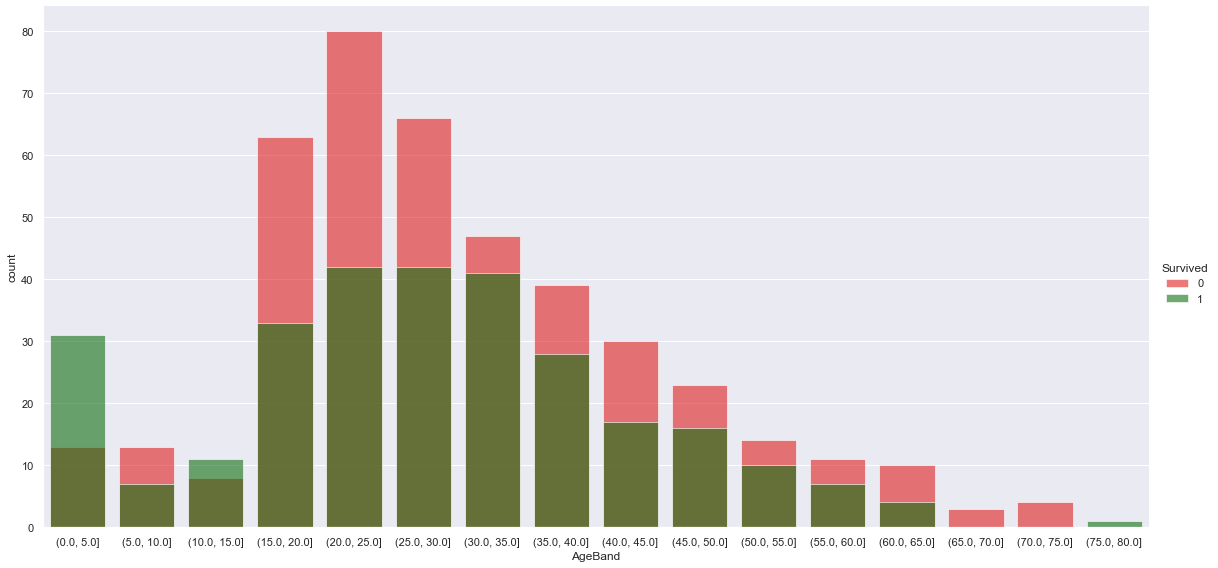

In [13]:
# Create age bins
# Use combined_df for max
age_bins = np.arange(0, combined_df['Age'].max() + 5, 5)

# Add age bins
train_df['AgeBand'] = pd.cut(train_df['Age'], age_bins)

sns.catplot(x='AgeBand', hue='Survived', palette=pal, data=train_df, kind='count', 
            dodge=False, alpha=0.6, height=8, aspect=2);

Survival chance is higher for younger passengers aged <= 5, 11-15 and older passengers > 75 although the number of passengers in that older age band is very small.

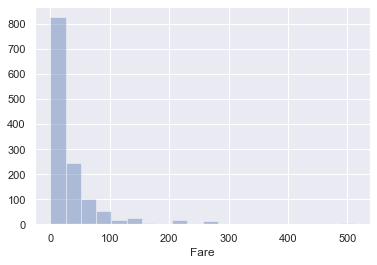

In [14]:
# Fare Histogram
sns.distplot(combined_df['Fare'].dropna(), bins=20, kde=False);

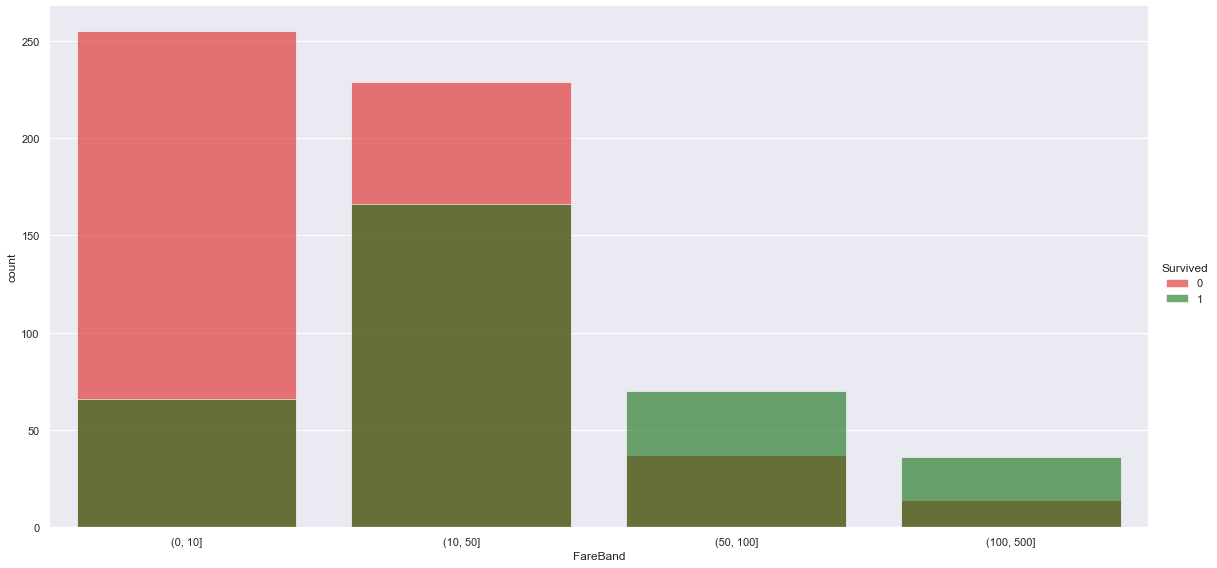

In [15]:
# Custom fare bins due to lower representation for higher fares
fare_bins = [0, 10, 50, 100, 500]

# Create fare bins
train_df['FareBand'] = pd.cut(train_df['Fare'], fare_bins)

# FareBand Survived Count plot
sns.catplot(x='FareBand', hue='Survived', palette=pal, data=train_df, kind='count', 
               dodge=False, alpha=0.6, height=8, aspect=2);

Survival chance is higher for passengers that paid fares > 50.  This could also be related to Pclass.

In [16]:
# Map letter to name of port function so visualizations are easier to know the ports
def map_embarked(df):
    emb_dict = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}
    
    df["Embarked"].replace(emb_dict, inplace=True)

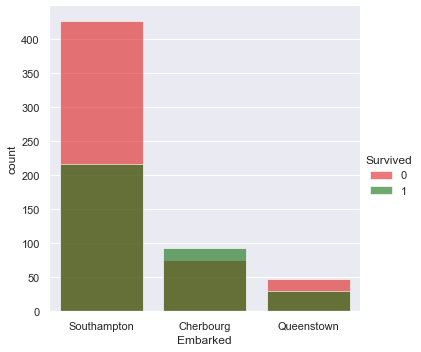

In [17]:
# Map Embarked
map_embarked(train_df)

# Embarked Survived Count plot
sns.catplot(x="Embarked", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

The majority of passengers embarked from the Southampton port.  Survival chance is slightly higher for passengers that embarked from Cherbourg.  Queenstown had the least number of passengers and survival chance is slightly lower.

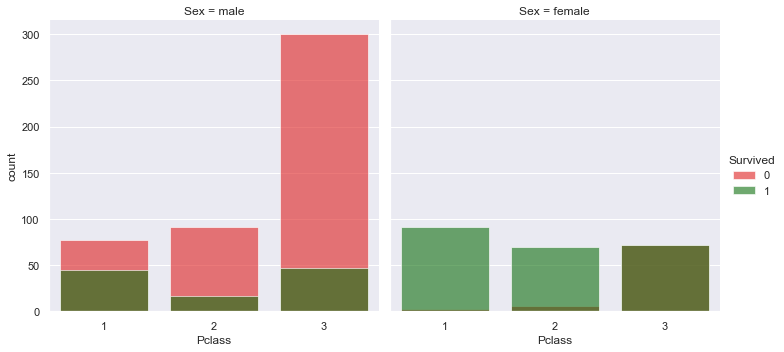

In [18]:
# Pclass, Sex and Survived Count plot
sns.catplot(x='Pclass', col='Sex', hue='Survived', palette=pal, data=train_df, kind='count', 
               dodge=False, alpha=0.6);

The majority of passengers were lower class male and did not survive.  Survival chance is high for upper and middle class females and virtually all first class female passengers survived.

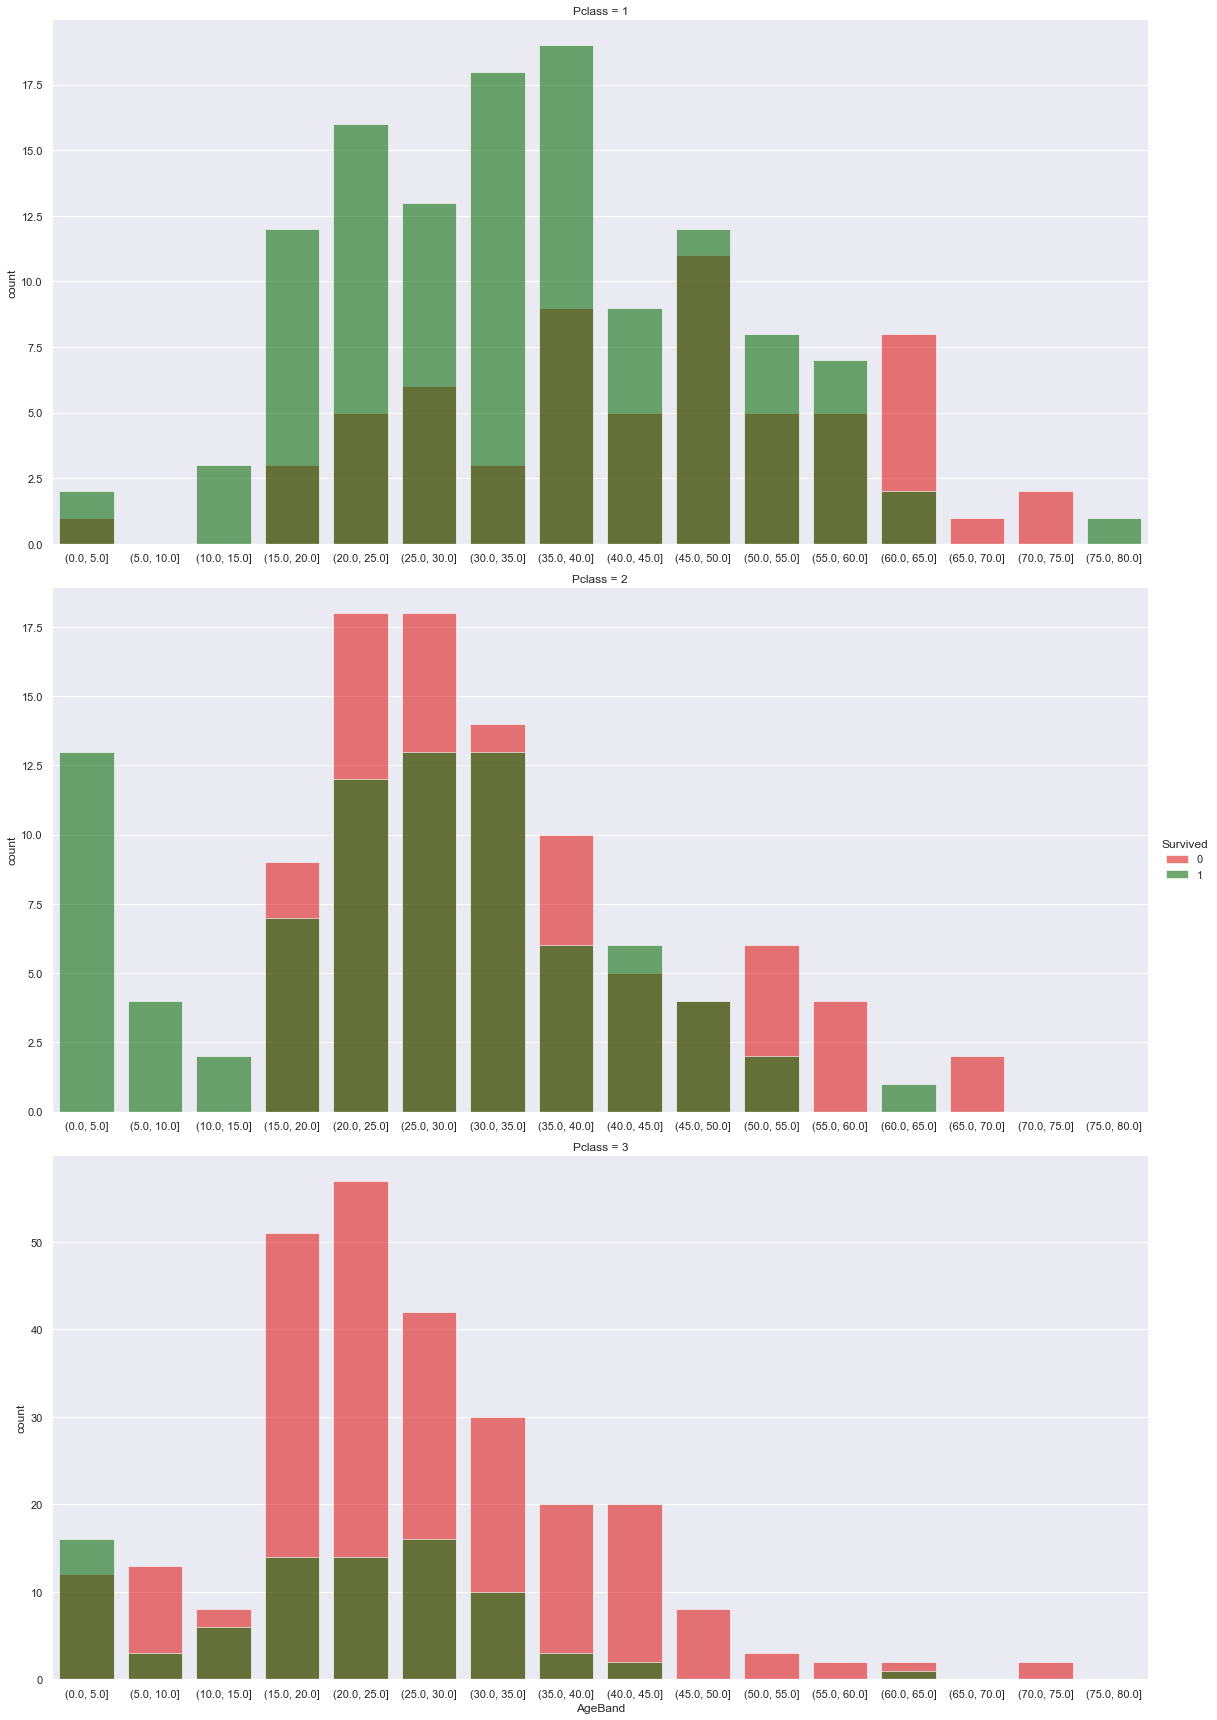

In [19]:
# Pclass, AgeBand and Survived Count plot
sns.catplot(x='AgeBand', row='Pclass', hue='Survived', palette=pal, data=train_df, kind='count', 
               sharex=False, sharey=False, dodge=False, alpha=0.6, height=8, aspect=2);

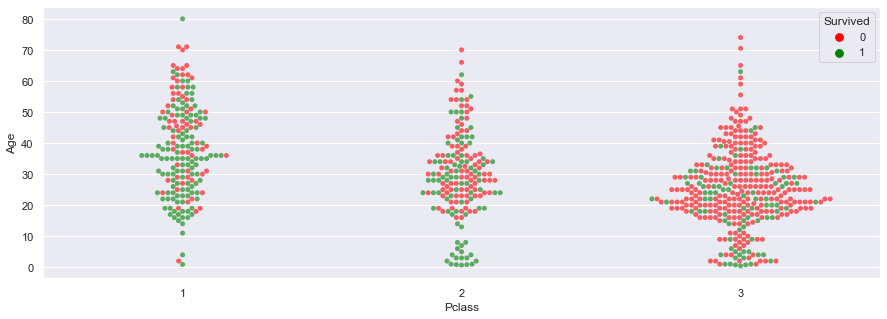

In [20]:
# Pclass, Age and Survived Swarm plot
fig, ax = plt.subplots(figsize=(15,5))
sns.swarmplot(x='Pclass', y='Age', hue='Survived', palette=pal, alpha = 0.6, data=train_df, ax=ax)
plt.legend(loc='upper right', title='Survived');

Survival chance is higher for upper class passengers age <= 60, middle class children <= 15 and lower class babies <= 5. There are only a few elderly > 65 passengers and all died except for the 1 passenger that was 80.

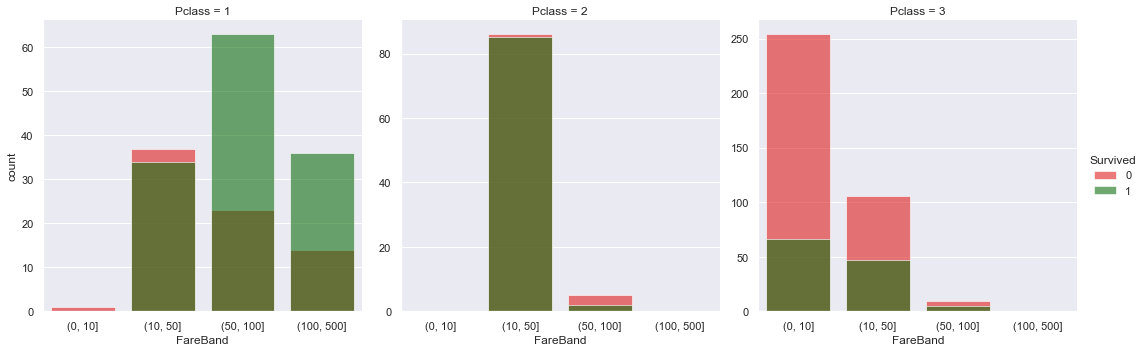

In [21]:
# Pclass, FareBand and Survived Count plot
sns.catplot(x='FareBand', col='Pclass', hue='Survived', palette=pal, data=train_df, kind='count', 
               sharex=False, sharey=False, dodge=False, alpha=0.6);

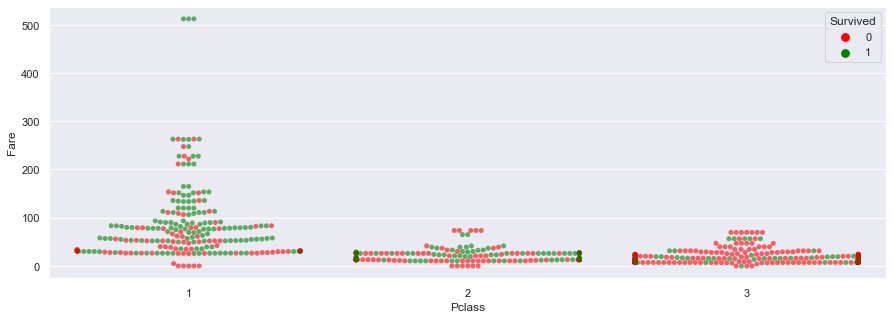

In [22]:
# Pclass, Fare and Survived Swarm plot
fig, ax = plt.subplots(figsize=(15,5))
sns.swarmplot(x='Pclass', y='Fare', hue='Survived', palette=pal, alpha = 0.6, data=train_df, ax=ax)
plt.legend(loc='upper right', title='Survived');

The majority of passengers were lower class that paid fares < 10 and did not survive.  Survival chance is higher for upper class passengers that paid fares > 50.

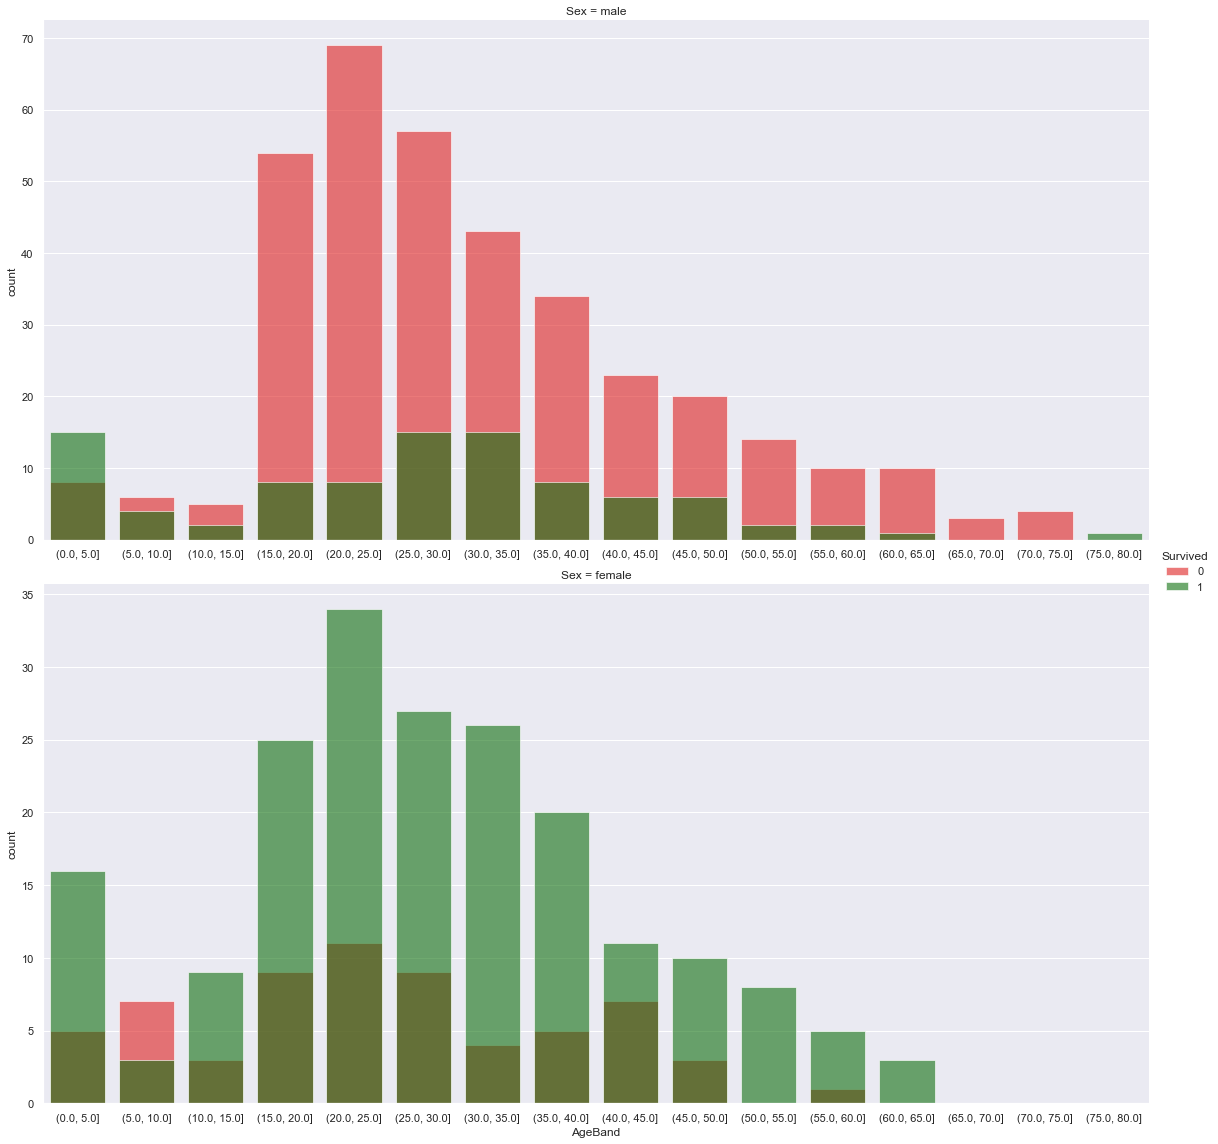

In [23]:
# age, Sex and Survived Count plot
sns.catplot(x='AgeBand', row='Sex', hue='Survived', palette=pal, data=train_df, kind='count', 
               sharex=False, sharey=False, dodge=False, alpha=0.6, height=8, aspect=2);

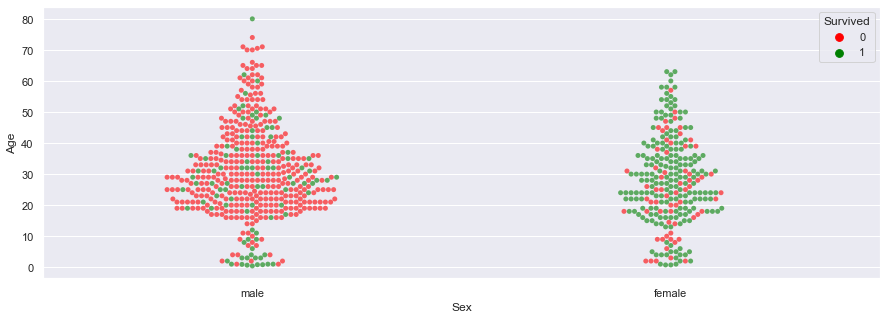

In [24]:
# Sex, Age and Survived Swarm plot
fig, ax = plt.subplots(figsize=(15,5))
sns.swarmplot(x='Sex', y='Age', hue='Survived', palette=pal, alpha = 0.6, data=train_df, ax=ax)
plt.legend(loc='upper right', title='Survived');

Survival chance is higher for male children <= 5.  All of the elderly passengers > 70 in the training set were male and the 1 passenger that was 80 survived.

In [25]:
# Extract Title function
def extract_title(df):
    
    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand=False)

In [26]:
# Extract title from Name
extract_title(combined_df)

# Crosstab by Sex and Pclass
pd.crosstab([combined_df['Sex'], combined_df['Title']], combined_df['Pclass'])

Pclass             1    2    3
Sex    Title                  
female Countess    1    0    0
       Dona        1    0    0
       Dr          1    0    0
       Lady        1    0    0
       Miss       60   50  150
       Mlle        2    0    0
       Mme         1    0    0
       Mrs        77   55   65
       Ms          0    1    1
male   Capt        1    0    0
       Col         4    0    0
       Don         1    0    0
       Dr          5    2    0
       Jonkheer    1    0    0
       Major       2    0    0
       Master      5   11   45
       Mr        159  150  448
       Rev         0    8    0
       Sir         1    0    0

The majority of passengers default titles are Mr or Master for males and Miss, Mrs and Ms for females.  Master is a title generally used for male children and Miss can be used for unmarried females or female children.  Mme and Mlle is just an alternative for an unmarried woman.  Ms is used when the marital status is unknown.  Mme, Mlle and Ms will be updated to Miss.

We have a variety of other titles. Some quick wikipedia/dictionary searches and we learn some of these titles are representative of nobility or a person of rank.

Female Nobility:
* Countess - woman who holds in her own right the rank of earl or count
* Dona - a Portuguese or Brazilian woman of rank
* Lady - a title of nobility, the uses of "lady" in Britain are parallel to those of "lord"

Male Rank:
* Capt - a commissioned officer rank
* Col -  a senior military officer rank
* Don - honorific title that conveys esteem or respect for position or rank
* Jonkheer - Dutch honorific of nobility
* Major - a military rank of commissioned officer status
* Sir - A title of honour for a knight

It was already observed females had a higher survival rate.  An assumption is a female of higher stature would have even a higher survival chance whereas a male passenger of rank would take actions to save others.  Therefore, based on this assumption we will use Nobility for females and Rank for males.

Dr and Rev will be updated to Mr or Ms based on their Sex.

In [27]:
# Update Title function
def update_title(df):

    # Extract Title
    extract_title(df)

    # Replace to Miss
    df['Title'] = df['Title'].replace('Mme', 'Miss')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    
    # Replace to Mrs/Mr
    df.loc[(df['Sex'] == 'female') & (df['Title'] == 'Dr'), 'Title'] = 'Mrs'
    df.loc[(df['Sex'] == 'male') & (df['Title'] == 'Dr'), 'Title'] = 'Mr'
    df.loc[(df['Sex'] == 'male') & (df['Title'] == 'Rev'), 'Title'] = 'Mr'

    # Definte default titles
    DefaultTitles = ['Mr', 'Mrs', 'Master', 'Miss']
    
    NobilityTitles = ['Countess', 'Dona', 'Lady']
    RankTitles = ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Sir']
    
    Combined = DefaultTitles + NobilityTitles + RankTitles

    # Get unique titles
    Titles = list(df.Title.unique())
    
    # Create list of Other titles
    OtherTitles = [x for x in Titles if x not in Combined]

    # Update Nobility
    df['Title'] = df['Title'].replace(NobilityTitles, 'Nobility')

    # Update Rank
    df['Title'] = df['Title'].replace(RankTitles, 'Rank')

    # Update the rest to Other (if any not addressed above)
    if len(OtherTitles) > 0:
        df['Title'] = df['Title'].replace(OtherTitles, 'Other')

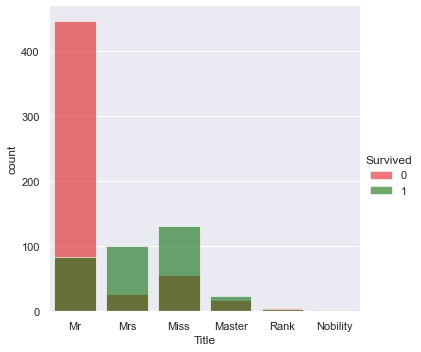

In [28]:
# Update Title
update_title(train_df)

# Title Survived Count plot
sns.catplot(x="Title", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

The number of passengers with the rare nobility/rank titles is very low but all female of nobility survived.  Survival chance is higher for male passengers with a Master title.

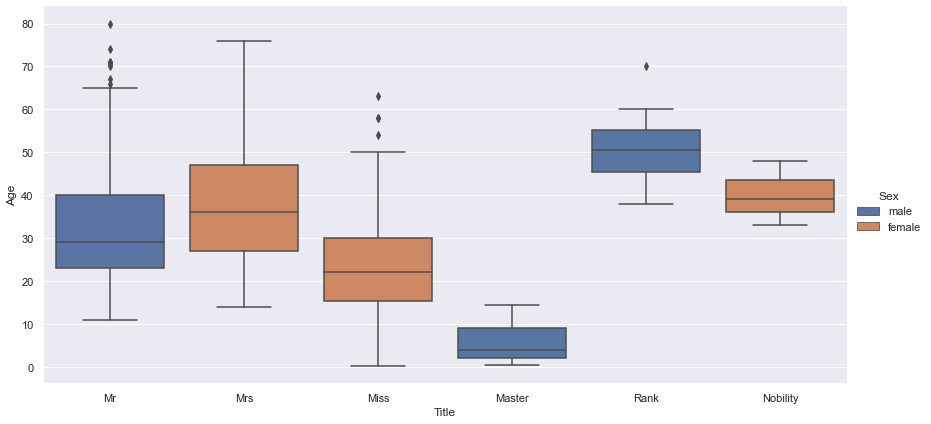

In [29]:
# Update Title
update_title(combined_df)

# Age, Sex and Title Box plot
sns.catplot(x='Title', y='Age', hue='Sex', data=combined_df, kind="box", dodge=False, height=6, aspect=2);

Titles now inherently imply the sex of the passenger.  Median age is different across all.

In [30]:
# Create Extract Ticket Letters function
def extract_ticket_letters(df):

    # Extract all non-numeric characters from Ticket
    df['TicketLetters'] = df.Ticket.str.extract('([a-zA-Z]+)', expand=False)

    # Replace the numeric that are now NaN as X
    df['TicketLetters'] = df['TicketLetters'].fillna('X')

In [31]:
# Extract letters of Ticket
extract_ticket_letters(combined_df)

# Crosstab by Pclass
pd.crosstab(combined_df['TicketLetters'], combined_df['Pclass'])

Pclass,1,2,3
TicketLetters,,,
A,0,0,40
AQ,0,0,2
C,0,32,23
CA,0,2,20
F,3,9,0
Fa,0,0,1
LINE,0,0,4
LP,0,0,1
P,0,2,0


The majority of tickets were numeric denoted by X.

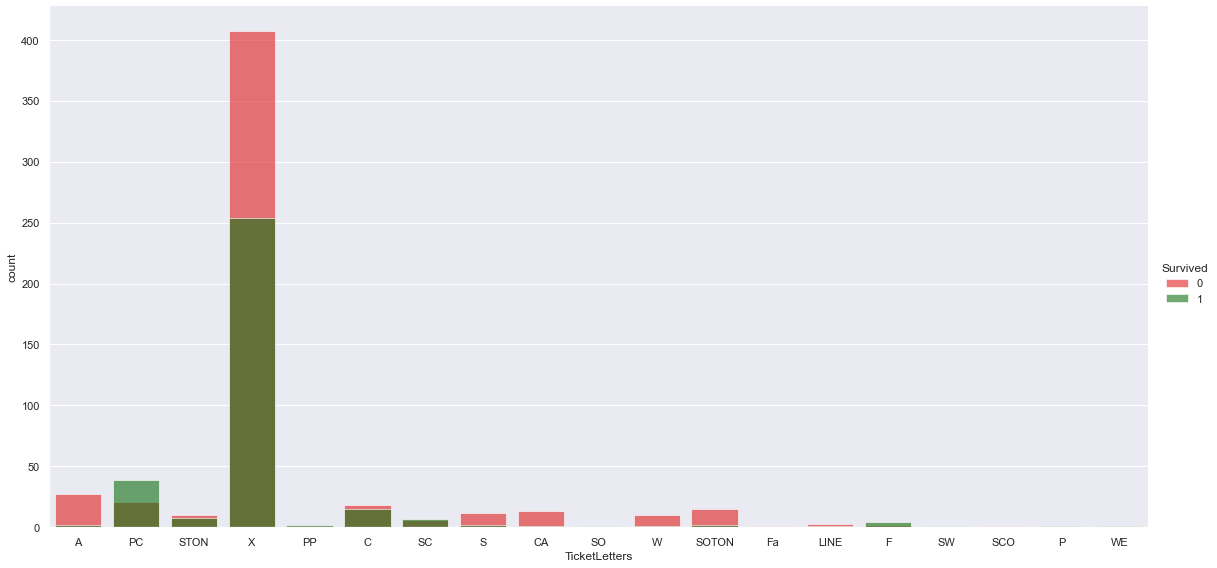

In [32]:
# Extract letters of Ticket
extract_ticket_letters(train_df)

# Title Survived Count plot
sns.catplot(x="TicketLetters", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6, height=8, aspect=2);

Survival chance is higher for passengers with ticket letter prefix PC and F but the number of passengers is low.

In [33]:
# Create Ticket Group function
def create_ticket_count(df):
    
    # Create Ticket Count
    df['TicketCount'] = df.groupby('Ticket')['Ticket'].transform('count')

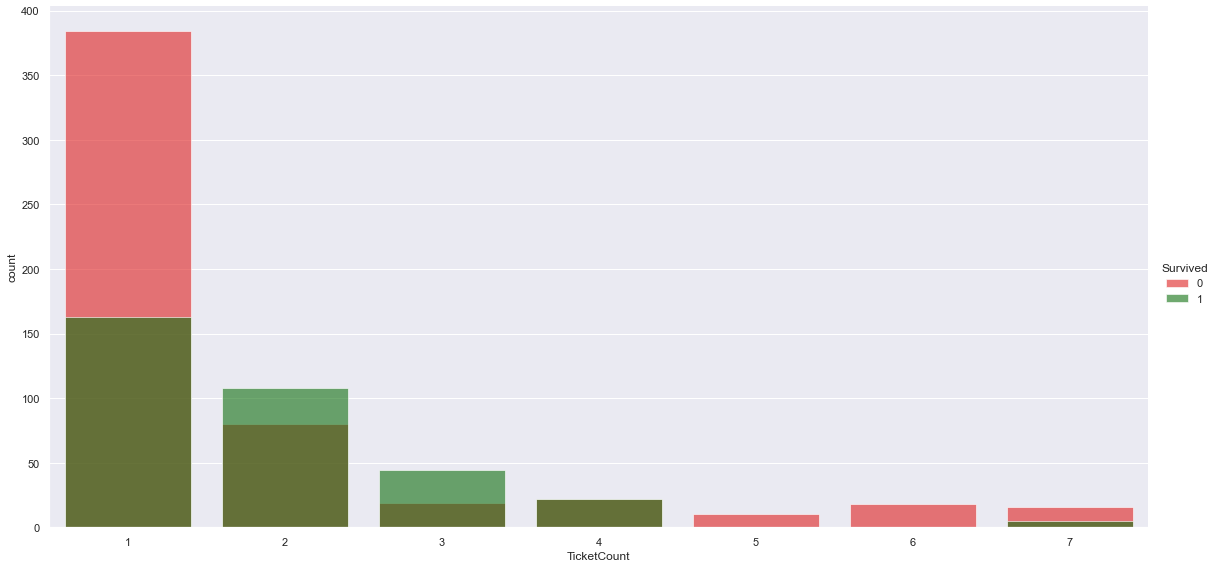

In [34]:
# Create TicketCount
create_ticket_count(train_df)

# TicketCount Survived Count plot
sns.catplot(x="TicketCount", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6, height=8, aspect=2);

Survival chance is higher for passengers that shared a ticket with 1-2 other passengers but decreases as more passengers shared the ticket.

In [35]:
# Create Ticket Group function
def create_ticket_group(df):
    
    # Single ticket
    df.loc[(df['TicketCount'] == 1), 'TicketGroup'] = 'Single'
    
    # With a Small Group
    df.loc[(df['TicketCount'] >= 2) & (df['TicketCount'] < 4), 'TicketGroup'] = 'Small'

    df.loc[(df['TicketCount'] >= 4), 'TicketGroup'] = 'Large'

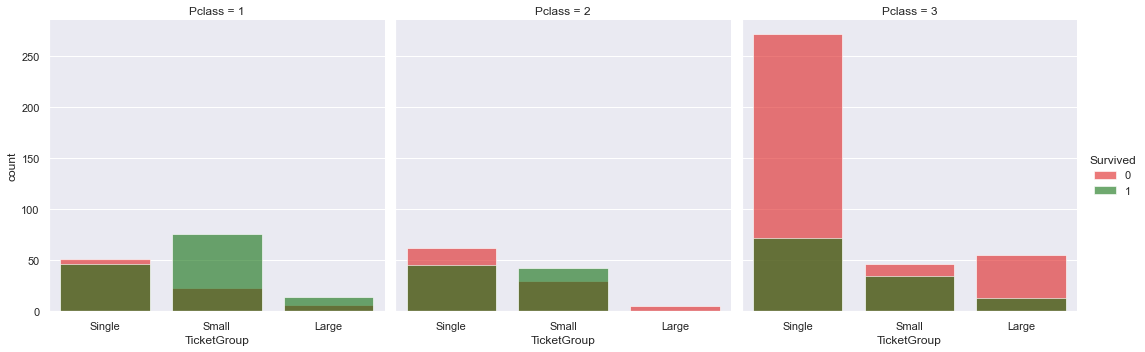

In [36]:
# Create TicketGroup
create_ticket_group(train_df)

# TicketGroup, Pclass and Survived Count plot
sns.catplot(x="TicketGroup", col='Pclass', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for first class passengers that are traveling with other passengers.  Survival chance is higher for middle class passengers traveling with 1-2 other passengers.

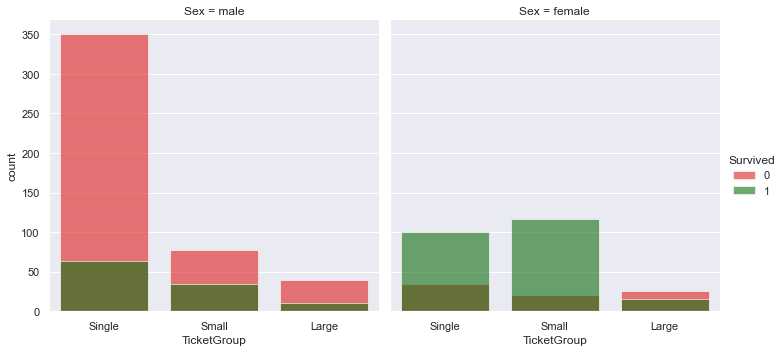

In [37]:
# TicketGroup, Sex and Survived Count plot
sns.catplot(x="TicketGroup", col='Sex', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance decreases for females traveling with 4+ passengers.

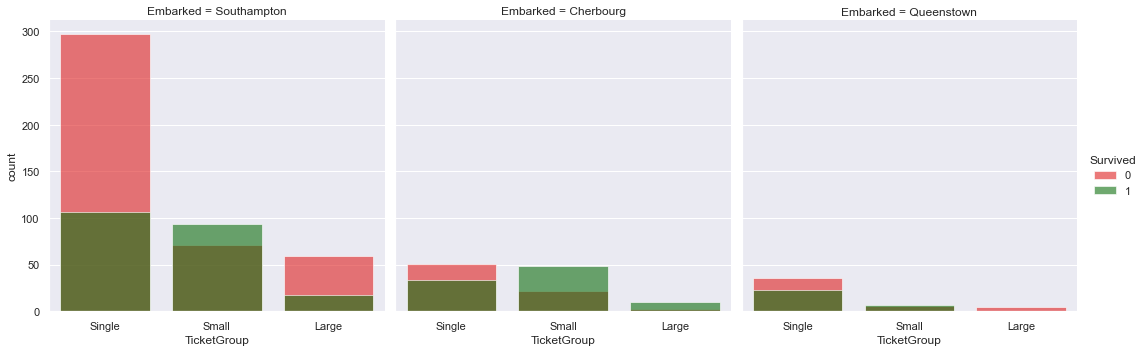

In [38]:
# TicketGroup, Sex and Survived Count plot
sns.catplot(x="TicketGroup", col='Embarked', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for passengers that embarked from Cherbourg and traveling with other passengers.  Survival chance is higher for passengers that embarked from Southampton and traveling with 1-2 other passengers.

In [39]:
# Create Extract Cabin Letter function
def extract_cabin_letter(df):
    
    # Fill blank with X
    df['Cabin'] = df['Cabin'].fillna('X')

    # Extract first non-numeric character from Cabin
    df['CabinLetter'] = df.Cabin.str.extract('(\D)', expand=False)

In [40]:
# Extract first letter of Cabin and crosstab by Pclass
extract_cabin_letter(combined_df)

pd.crosstab(combined_df['CabinLetter'], combined_df['Pclass'])

Pclass,1,2,3
CabinLetter,,,
A,22,0,0
B,65,0,0
C,94,0,0
D,40,6,0
E,34,4,3
F,0,13,8
G,0,0,5
T,1,0,0
X,67,254,693


The majority of passengers did not have a cabin denoted by X.  Passengers with cabin letter A, B and C are all upper class.  There was only 1 passenger with cabin letter T.

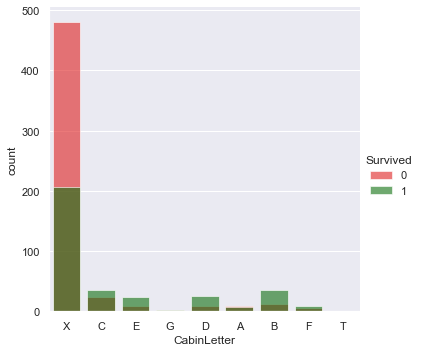

In [41]:
# Extract CabinLetter
extract_cabin_letter(train_df)

# CabinLetter Survived Count plot
sns.catplot(x="CabinLetter", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for cabin letters, C, E, D, B and F but the number of passengers is low.

In [42]:
# Create InCabin function
def create_in_cabin(df):
    
    # InCabin
    df['InCabin'] = df['Cabin'].apply(lambda x: 1 if x != 'X' else 0)

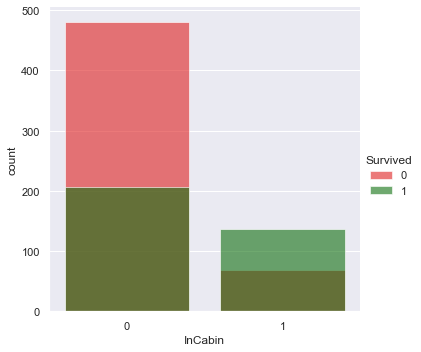

In [43]:
# Create InCabin
create_in_cabin(train_df)

# InCabin Survived Count plot
sns.catplot(x="InCabin", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher generally for passengers in a cabin.

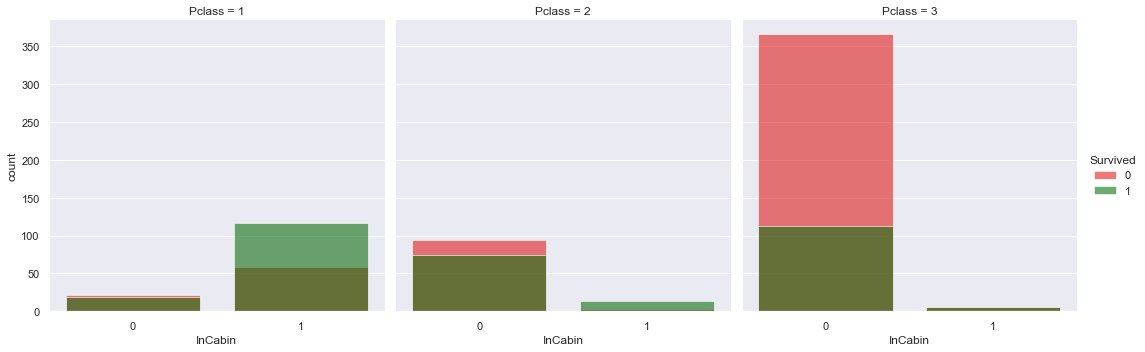

In [44]:
# InCabin, Pclass and Survived Count plot
sns.catplot(x="InCabin", col='Pclass', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for first class passengers in a cabin.  Very few middle and lower class passengers were in a cabin but survival chance is higher for middle class passengers.

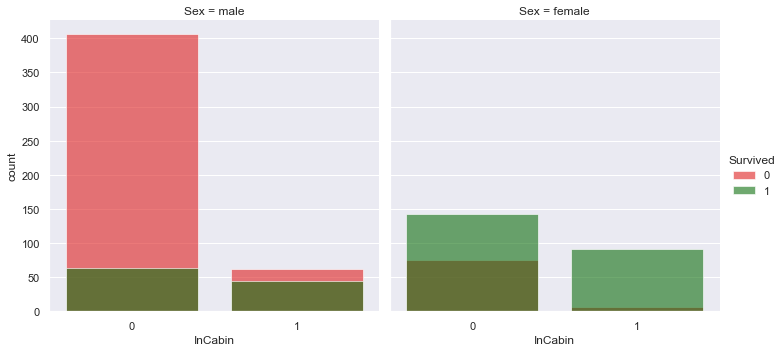

In [45]:
# InCabin, Sex and Survived Count plot
sns.catplot(x="InCabin", col='Sex', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is very high for females and increases for males in a cabin.

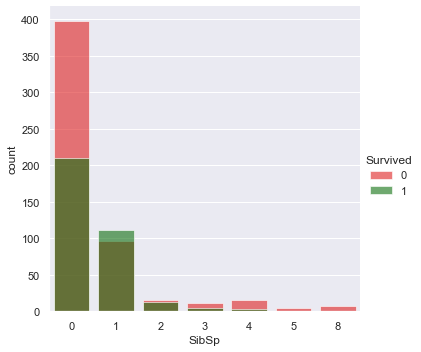

In [46]:
# SibSp and Survived Count plot
sns.catplot(x="SibSp", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher when there is 1 sibling/spouse aboard.

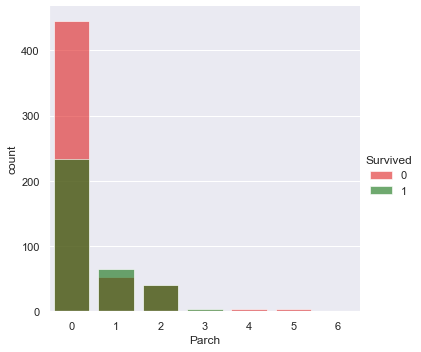

In [47]:
# Parch and Survived Count plot
sns.catplot(x="Parch", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Similar to SibSp survival chance is higher when there is 1 parent/child aboard.  Family size on board could be created by adding 1 + SibSp + Parch.

In [48]:
# Create FamilySize function
def create_family_size(df):
    
    # FamilySize is self + siblings/spouse + parents/children
    df['FamilySize'] = 1 + df['SibSp'] + df['Parch']

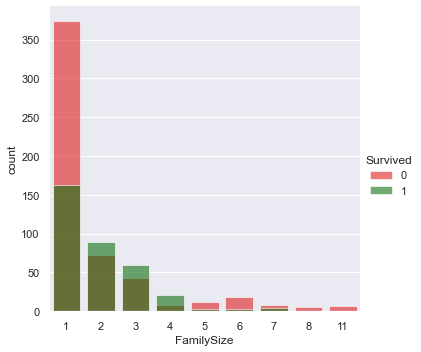

In [49]:
# Add FamilySize
create_family_size(train_df)

# Family Size and Survived Count plot
sns.catplot(x="FamilySize", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for family sizes 2-4.

In [50]:
# Create FamilyGroup function
def create_family_group(df):

    # Create Family_Group feature based Family_Size
    df.loc[(df['FamilySize'] == 1), 'FamilyGroup'] = 'Alone'
    df.loc[(df['FamilySize'] > 1) & (df['FamilySize'] <= 4), 'FamilyGroup'] = 'Small'
    df.loc[(df['FamilySize'] > 4), 'FamilyGroup'] = 'Large'

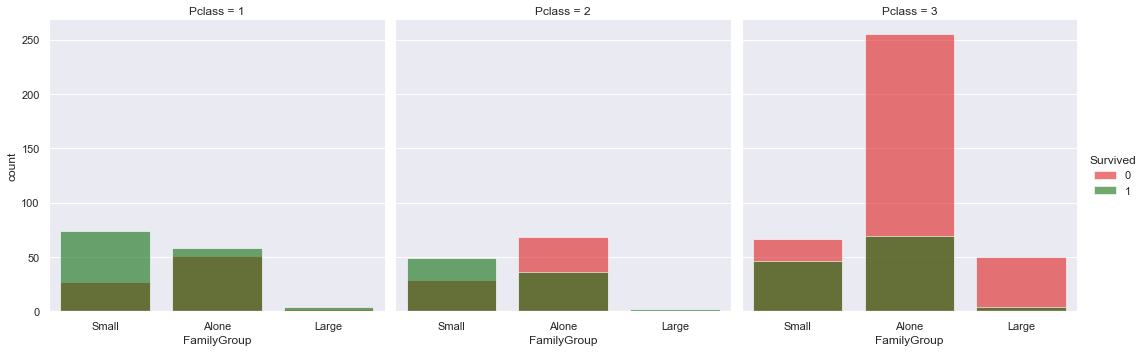

In [51]:
# Add Family_Group
create_family_group(train_df)

# FamilySize, Pclass and Survived Count plot
sns.catplot(x="FamilyGroup", col='Pclass', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for family sizes 2-4 primarily for upper and middle class passengers.

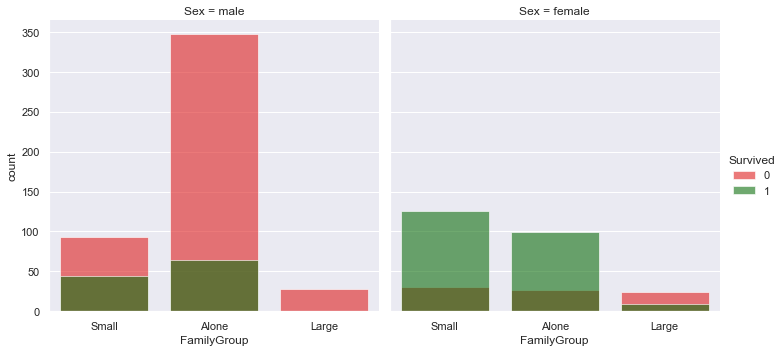

In [52]:
# FamilySize, Sex and Survived Count plot
sns.catplot(x="FamilyGroup", col='Sex', hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Survival chance is higher for females with family sizes 2-4.  As family size increases survival chance decreases for females (TicketCount is similar but not all passengers shared the same Ticket).

In [53]:
# NameId function
def create_name_id(df):
    
    # Split the name and then concat the 1st, Third and Family_Size to attempt to create a unique name identifier
    df['NameId'] = df['Name'].str.split(' ', 2, expand=True)[0] + \
    df['Name'].str.split(' ', 3, expand=True)[2] + \
    df['FamilySize'].map(str)

    # Count of passengers with the same NameId
    df['NameCount'] = df.groupby('NameId')['NameId'].transform('count')

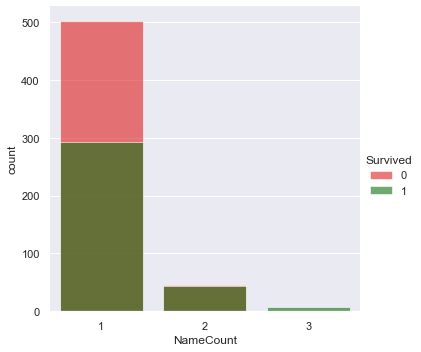

In [54]:
# Add NameId/NameCount
create_name_id(train_df)

# NameCount and Survived Count plot
sns.catplot(x="NameCount", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

Nothing significant for passengers that share the same name.

In [55]:
# Extract Surname function
def extract_surname(df):
    
    # Extract surname everything left of the comma
    df['Surname'] = df.Name.str.extract('([A-Za-z]+)\,', expand=False)

In [56]:
def create_family_id(df):
    
    # Concat Surname and FamilySize to create a unique family identifier
    df['FamilyId'] = df['Surname'].map(str) + '-' + df['FamilySize'].map(str)
    
    # Count of passengers with the same FamilyId
    df['FamilyCount'] = df.groupby('FamilyId')['FamilyId'].transform('count') 

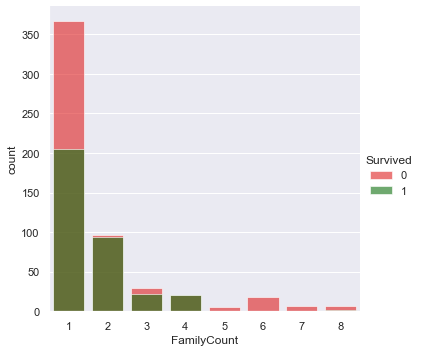

In [57]:
# Extract Surname
extract_surname(train_df)

# Create FamilyId
create_family_id(train_df)

# FamilyCount and Survived Count plot
sns.catplot(x="FamilyCount", hue="Survived", palette=pal, data=train_df, kind="count", 
               dodge=False, alpha=0.6);

FamilyCount is similar to FamilySize but only counts individuals with the same Surname and FamilySize.  Nothing significant for passengers based on count of family members.

Let's recap some of the key findings for higher survival chance:

- Pclass 1
 - Age <= 60
 - Fare > 50
 - In Cabin
 - Family Size 2-4
- Pclass 2
 - Age <= 15
 - In Cabin
 - Family Size 2-4
- Pclass 3
 - Age <= 5
 
- Female
 - Pclass 1 and 2
 - Alone/Single Ticket and Family Size 2-4/Small Ticket Group 2-3
- Male
 - Age <= 5/Master Title
 
- Fare > 50
- Family Size 2-4
- Ticket Count 2-3
- In Cabin
- Embarked Cherbourg

## Prepare features

We need to perform the following steps to prepare features for modeling:

1. Create dummy features for Pclass.
2. Create Female binary feature.
3. Create dummy features for Title.
4. Create InCabin binary feature.
5. Create dummy features for TicketGroup.
6. Create dummy features for FamilyGroup.
7. Replace missing Embarked values.
8. Create dummy features for Embarked.
9. Replace missing Fare values.
10. Replace missing Age values.

In [58]:
# Create a function to drop columns from a list
def drop_cols(df, col_list):
    for column in col_list:
        try:
            df.drop(column, axis=1, inplace=True)
        except:
            continue

In [59]:
# Create dummy features function
def create_dummy(df, col, col_prefix):
    
    # Dummy df
    dummy = pd.get_dummies(df[col], prefix=col_prefix)
    
    # Dummy column names to list
    dummy_cols = list(dummy)
    
    # To avoid concat duplicate dummy columns drop all dummy columns first
    drop_cols(df, dummy_cols)

    # Add new dummy features
    df_out = pd.concat([df, dummy], axis=1)
    
    print('Done!')

    return df_out

In [60]:
# Create a function to check for blank values
def check_blanks(df, col_name):
    if df[col_name].isnull().values.any() == False:
        print('No blank values found!')
    else:
        print('Try again!')

In [61]:
# Create Pclass dummy features 
combined_df = create_dummy(combined_df, 'Pclass', 'Class')

Done!


In [62]:
# Create Female function
def create_female(df):

    # Create a new column Female.  Sex can be dropped later this preserves original data
    df['Female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)

In [63]:
# Create Female
create_female(combined_df)

# Confirm counts for Female
combined_df['Female'].value_counts(dropna=False)

0    843
1    466
Name: Female, dtype: int64

In [64]:
# Confirm counts for Title that was extracted and updated earlier
combined_df['Title'].value_counts(dropna=False)

Mr          772
Miss        265
Mrs         198
Master       61
Rank         10
Nobility      3
Name: Title, dtype: int64

In [65]:
# Create Title dummy features
combined_df = create_dummy(combined_df, 'Title', 'Title')

Done!


In [66]:
# Extract CabinLetters
extract_cabin_letter(combined_df)

# Create InCabin
create_in_cabin(combined_df)

# Confirm counts for InCabin
combined_df['InCabin'].value_counts(dropna=False)

0    1014
1     295
Name: InCabin, dtype: int64

In [67]:
# Create TicketCount
create_ticket_count(combined_df)

# Create TicketGroup
create_ticket_group(combined_df)

# Confirm counts for TicketGroup
combined_df['TicketGroup'].value_counts(dropna=False)

Single    713
Small     411
Large     185
Name: TicketGroup, dtype: int64

In [68]:
# Create TicketGroup dummy features
combined_df = create_dummy(combined_df, 'TicketGroup', 'Ticket')

Done!


In [69]:
# Create FamilySize
create_family_size(combined_df)

# Create FamilyGroup
create_family_group(combined_df)

# Confirm counts for FamilyGroup
combined_df['FamilyGroup'].value_counts(dropna=False)

Alone    790
Small    437
Large     82
Name: FamilyGroup, dtype: int64

In [70]:
# Create FamilyGroup dummy features
combined_df = create_dummy(combined_df, 'FamilyGroup', 'Family')

Done!


In [71]:
# Create function to update Embarked with most common port 
def update_embarked(df):

    # Get most common port
    most_common_port = df['Embarked'].mode()[0]

    # Replace missing Embarked values with the most common port
    df['Embarked'] = df['Embarked'].fillna(most_common_port)

In [72]:
# Update Embarked in combined dataset and confirm no blanks
update_embarked(combined_df)

# Confirm blank Embarked values
check_blanks(combined_df, 'Embarked')

No blank values found!


In [73]:
# Map Embarked
map_embarked(combined_df)

# Create Port dummy features
combined_df = create_dummy(combined_df, 'Embarked', 'Port')

Done!


In [74]:
# Fare only had 1 missing value so will update with median value based on Pclass, CabinLetter and Title
# Create function to update Fare with median age by Pclass, CabinLetter and Title
def update_fare(df):
    
    df['Fare'] = df.groupby(['Pclass', 'CabinLetter', 'Title'])['Fare'].transform(lambda x: x.fillna(x.median()))

In [75]:
# Update Fare in combined dataset and confirm no blanks
update_fare(combined_df)

# Confirm blank Fare values
check_blanks(combined_df, 'Fare')

No blank values found!


Age has 263 missing values so an accurate estimate of the passengers age could impact model performance.  We will experiment with 2 different approaches:

1. Median value based on Title, Pclass, InCabin and FamilyGroup
2. DecisionTreeRegressor model to predict Age

In [76]:
# Create a copy of combined_df for rows that Age is not null
age_update = combined_df[combined_df['Age'].notnull()].copy()

age_median_cols = ['Title', 'Pclass','InCabin', 'FamilyGroup']

# Create a column to hold AgeMedian value
age_update['AgeMedian'] = age_update.groupby(age_median_cols)['Age']\
.transform(lambda x: x.median())

In [77]:
from sklearn.metrics import mean_absolute_error

print("Mean absolute error for Age and Median Age is: {:,.2f}".\
format(mean_absolute_error(age_update['Age'], age_update['AgeMedian'])))

Mean absolute error for Age and Median Age is: 7.86


In [78]:
# Create a copy of combined_df for rows that Age is not null
age_features = combined_df[combined_df['Age'].notnull()].copy()

# Age values
age = age_features['Age']

# Create a copy of combined_df for rows that Age is null
age_missing = combined_df[combined_df['Age'].isnull()].copy()

# Store PassengerId from age_missing to help with updating missing values
age_passengerid = age_missing['PassengerId']

In [79]:
# Drop columns that will not be included in model training
age_drop = ['Age', 'Cabin', 'Embarked', 'Fare', 'Survived', 'Name', 'PassengerId', 'Pclass', 
            'Sex', 'Ticket', 'Parch', 'SibSp', 'Source', 'Ticket', 'Title', 'TicketLetters', 'CabinLetter',
            'TicketCount', 'TicketGroup', 'FamilyGroup']

drop_cols(age_features, age_drop)
drop_cols(age_missing, age_drop)

In [80]:
# Set random seed for model reproducibility
SEED = 23

np.random.seed(SEED)

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# DecisionTreeRegressor
dt = DecisionTreeRegressor()

dt_fs = SelectFromModel(dt, threshold=.01)

dt_pipe = Pipeline([('fs', dt_fs), ('clf', dt)])

dt_params = {'fs__threshold': [0.005, .01, .05, .1],
             'clf__max_depth': range(1,11),
             'clf__max_features': ['sqrt', 'log2']}

dt_grid = GridSearchCV(dt_pipe, param_grid = dt_params, scoring='neg_mean_absolute_error', cv=5)

dt_grid.fit(age_features, age);

In [82]:
# Create Age predictions
age_pred = dt_grid.predict(age_features)

print("Mean absolute error for Age and Predicted Age is: {:,.2f}".\
format(mean_absolute_error(age, age_pred)))

Mean absolute error for Age and Predicted Age is: 8.06


In [83]:
# Create function to update Age with median age
def update_age(df):
    
    df['Age'] = df.groupby(age_median_cols)['Age'].transform(lambda x: x.fillna(x.median()))
    
    # Sweep remaining since some combinations for InCabin and FamilyGroup may not have values
    df['Age'] = df.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [109]:
# Update Age in combined dataset and confirm no blanks
update_age(combined_df)

# Confirm blank Fare values
check_blanks(combined_df, 'Age')

No blank values found!


In [85]:
# Combined dataset info
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       1309 non-null   int64  
 1   Survived          891 non-null    float64
 2   Pclass            1309 non-null   int64  
 3   Name              1309 non-null   object 
 4   Sex               1309 non-null   object 
 5   Age               1309 non-null   float64
 6   SibSp             1309 non-null   int64  
 7   Parch             1309 non-null   int64  
 8   Ticket            1309 non-null   object 
 9   Fare              1309 non-null   float64
 10  Cabin             1309 non-null   object 
 11  Embarked          1309 non-null   object 
 12  Source            1309 non-null   object 
 13  Title             1309 non-null   object 
 14  TicketLetters     1309 non-null   object 
 15  CabinLetter       1309 non-null   object 
 16  Class_1           1309 non-null   uint8  
 

## Modeling

In [86]:
# Create Submission function
def create_submission(clf, features_test):

    # Create survived predictions
    pred = clf.predict(features_test)

    # Create array for PassengerId from original test df
    passenger_id = (test_df['PassengerId'].values)

    # Create submission df
    submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': pred.astype(int)})
    
    return submission

In [87]:
# Create csv output function
def create_output(submission, output):

    # Create submission csv
    submission.to_csv(output, index=False)

In [88]:
# Create copy of df
combined_df_copy = combined_df.copy()

# Drop columns that will not be included in model training
cols = ['Cabin', 'Embarked', 'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 
        'Parch', 'SibSp', 'AgeBand', 'FareBand', 'Title', 'TicketLetters', 'TicketGroup', 
        'CabinLetter', 'NameId', 'Surname',  'FamilyId', 'FamilyGroup']

drop_cols(combined_df_copy, cols)

combined_df_copy.shape

(1309, 26)

In [89]:
# Create training data from combined
features_train = combined_df_copy[combined_df_copy['Source'] == 'Training'].copy()

features_train.shape

(891, 26)

In [90]:
# Create test data from combined
features_test = combined_df_copy[combined_df_copy['Source'] == 'Test'].copy()

features_test.shape

(418, 26)

In [91]:
# Create labels from train (need to convert back to int from combined_df)
labels_train = features_train['Survived'].astype(int)

labels_train.shape

(891,)

In [92]:
# Drop Source and Survived columns now
cols2 = ['Source','Survived']
drop_cols(features_train, cols2)
drop_cols(features_test, cols2)

features_train.shape

(891, 24)

In [93]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               891 non-null    float64
 1   Fare              891 non-null    float64
 2   Class_1           891 non-null    uint8  
 3   Class_2           891 non-null    uint8  
 4   Class_3           891 non-null    uint8  
 5   Female            891 non-null    int64  
 6   Title_Master      891 non-null    uint8  
 7   Title_Miss        891 non-null    uint8  
 8   Title_Mr          891 non-null    uint8  
 9   Title_Mrs         891 non-null    uint8  
 10  Title_Nobility    891 non-null    uint8  
 11  Title_Rank        891 non-null    uint8  
 12  InCabin           891 non-null    int64  
 13  TicketCount       891 non-null    int64  
 14  Ticket_Large      891 non-null    uint8  
 15  Ticket_Single     891 non-null    uint8  
 16  Ticket_Small      891 non-null    uint8  
 1

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

# Create a baseline classifier
rf_base = RandomForestClassifier(random_state=SEED)

# To evaluate the baseline model with no tuning I will use a tts approach
X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, 
                                                    test_size=.20, random_state=SEED)

# Fit baseline model
rf_base.fit(X_train, y_train)

rf_base_pred = rf_base.predict(X_test)

base_score = accuracy_score(y_test, rf_base_pred)

print(f"Baseline model accuracy is {base_score*100:,.2f}%")

Baseline model accuracy is 80.45%


In [95]:
# Create function to plot feature importances
def plot_feature_importances(X, clf):
    fig, ax = plt.subplots() 
    features = X.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)


    plt.title('Feature Importances')
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')

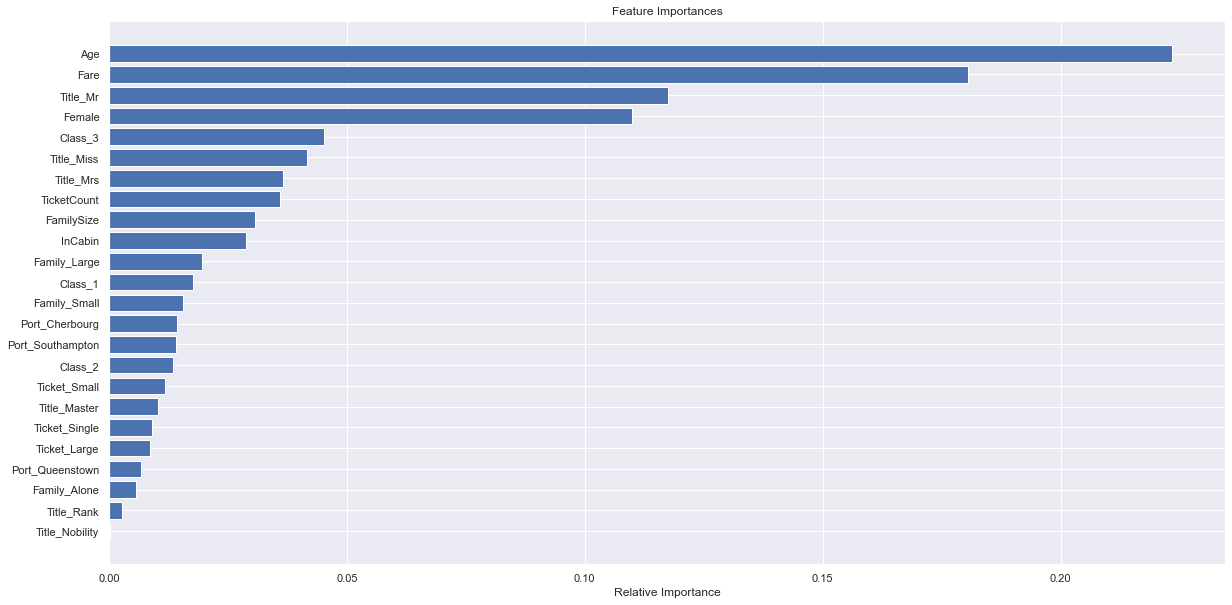

In [96]:
# Plot feature importances for baseline model
plt.rcParams["figure.figsize"] = (20,10)
plot_feature_importances(X_train, rf_base)

In [97]:
from sklearn.model_selection import validation_curve

def validation_curve_scores (clf, X, y, param_name, param_range, scorer):
    data = {}
    train_scores, test_scores = validation_curve(clf, X, y, param_name, param_range, scoring=scorer, cv=5)

    # Calculate mean and standard deviation of train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    data['param_name'] = param_name
    data['param_range'] = param_range
    data['train_scores_mean'] = train_scores_mean
    data['train_scores_std'] = train_scores_std
    data['test_scores_mean'] = test_scores_mean
    data['test_scores_std'] = test_scores_std
    data['scorer'] = scorer
    return data

In [98]:
def plot_validation_curve(data, ax=None):
    ax = ax or plt.gca()
    ax.set_title(f"Validation Curve for {data['param_name']}")
    ax.set_xlabel(data['param_name'])
    ax.set_ylabel(f"{data['scorer']} Score")
    lw = 2

    val_curve, = ax.plot(data['param_range'], data['train_scores_mean'], label="Training score",
                 color="darkorange", lw=lw)
    ax.fill_between(data['param_range'], data['train_scores_mean'] - data['train_scores_std'],
                     data['train_scores_mean'] + data['train_scores_std'], alpha=0.2,
                     color="darkorange", lw=lw)
    ax.plot(data['param_range'], data['test_scores_mean'], label="Cross-validation score",
                 color="navy", lw=lw)
    ax.fill_between(data['param_range'], data['test_scores_mean'] - data['test_scores_std'],
                     data['test_scores_mean'] + data['test_scores_std'], alpha=0.2,
                     color="navy", lw=lw)
    ax.set_xticks(data['param_range'])
    ax.legend(loc="best")
    return val_curve

In [99]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# Make Pipeline function to customize if a feature selection object is passed for the classifier
def model_pipeline(scaler, fi, clf):

    # If model has feature importances passed create feature selection
    if fi:
        fs = SelectFromModel(fi['fi'], threshold=fi['th'])
    else:
        fs = None

    # Create pipeline
    pipe = Pipeline([('scaler', scaler), ('fs', fs), ('clf', clf)])
    
    return pipe

In [100]:
# Create feature importances dict with no initial threshold
rf_fi = {'fi': rf_base, 'th': None}

# Create pipe
rf_pipe = model_pipeline(None, rf_fi, rf_base)

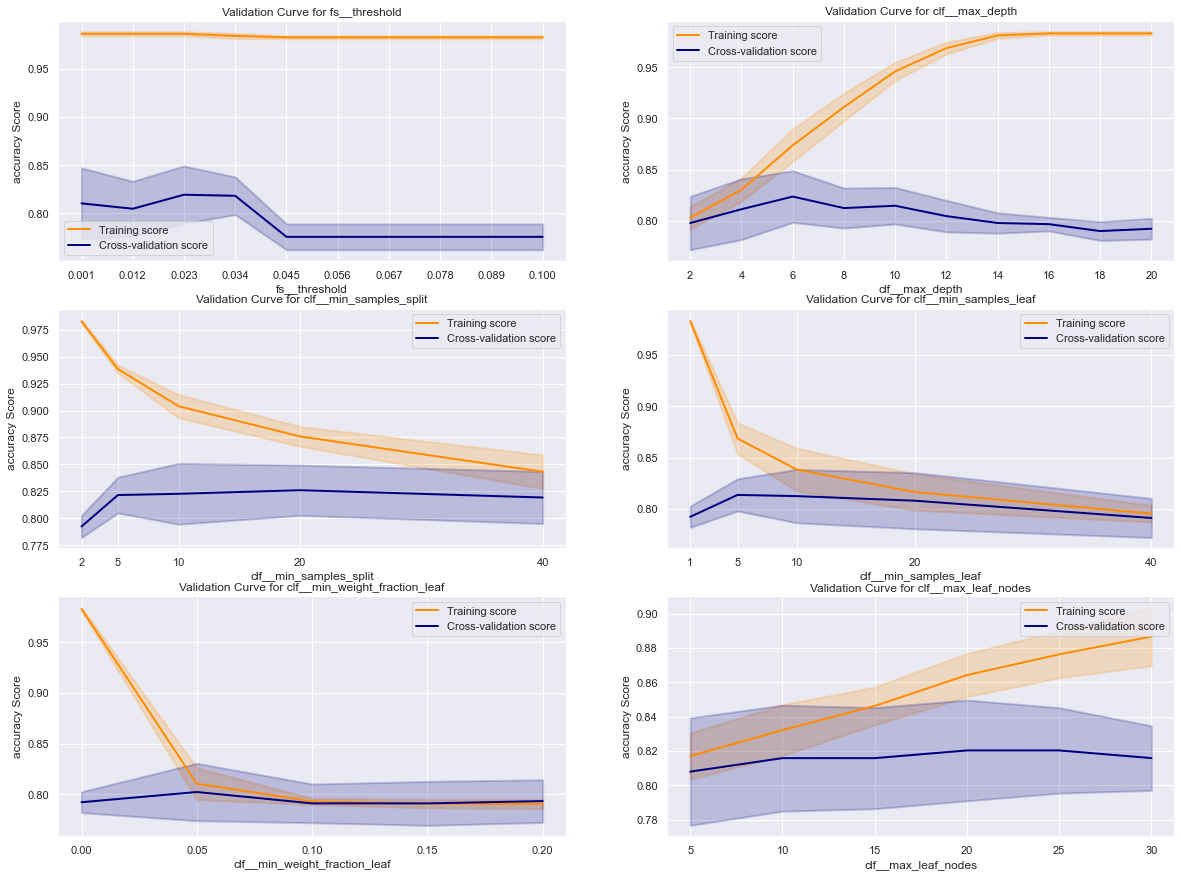

In [101]:
# Plot validation curves for some of key model parameters to help reduce the number of parameters needed to tune
fig, axes = plt.subplots(3, 2, figsize=(20,15))
axes = axes.flatten()
params = {'fs__threshold': np.linspace(0.001, .1, num=10),
          'clf__max_depth': np.arange(2, 22, 2),
          'clf__min_samples_split': [2, 5, 10, 20, 40],
          'clf__min_samples_leaf': [1, 5, 10, 20, 40],
          'clf__min_weight_fraction_leaf': np.arange(0.0, 0.25, .05),
          'clf__max_leaf_nodes': np.arange(5, 35, 5)
}
# Counter
i=0
for k, v in params.items():
    # Get validation curve score data
    data = validation_curve_scores (rf_pipe, features_train, labels_train, k, v, 'accuracy')
    # Plot validation curve
    val_curve = plot_validation_curve(data, ax=axes[i])
    # Increment index counter
    i+=1

In [102]:
# Grid Search function for optimal feature selection and parameters
from sklearn.model_selection import GridSearchCV

def grid_search(pipe, params, features, labels):
    
    grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=5)
    
    grid = grid.fit(features, labels)

    return grid

In [103]:
# Create new classifier based on learning curves to minimize parameters in the grid search
rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=2, 
                            min_weight_fraction_leaf=0.05, max_leaf_nodes=20, random_state=SEED)

rf_fi = {'fi': rf, 'th': None}

rf_pipe = model_pipeline(None, rf_fi, rf)

rf_params = {'fs__threshold': [.001, .02, None],
             'clf__max_depth': [4, 5, 6],
             'clf__criterion': ['gini', 'entropy'],
             'clf__max_features': ['sqrt', 'log2', None]
             }

rf_grid = grid_search(rf_pipe, rf_params, features_train, labels_train)

rf_grid.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', None),
                ('fs',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  ccp_alpha=0.0,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=20,
                                                                  max_samples=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
                                                                  m

In [104]:
# Best parameters from grid search
rf_grid.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 4,
 'clf__max_features': None,
 'fs__threshold': 0.001}

In [105]:
print(f"Tuned model cross-validation accuracy is {rf_grid.best_score_*100:,.2f}%")

Tuned model cross-validation accuracy is 83.16%


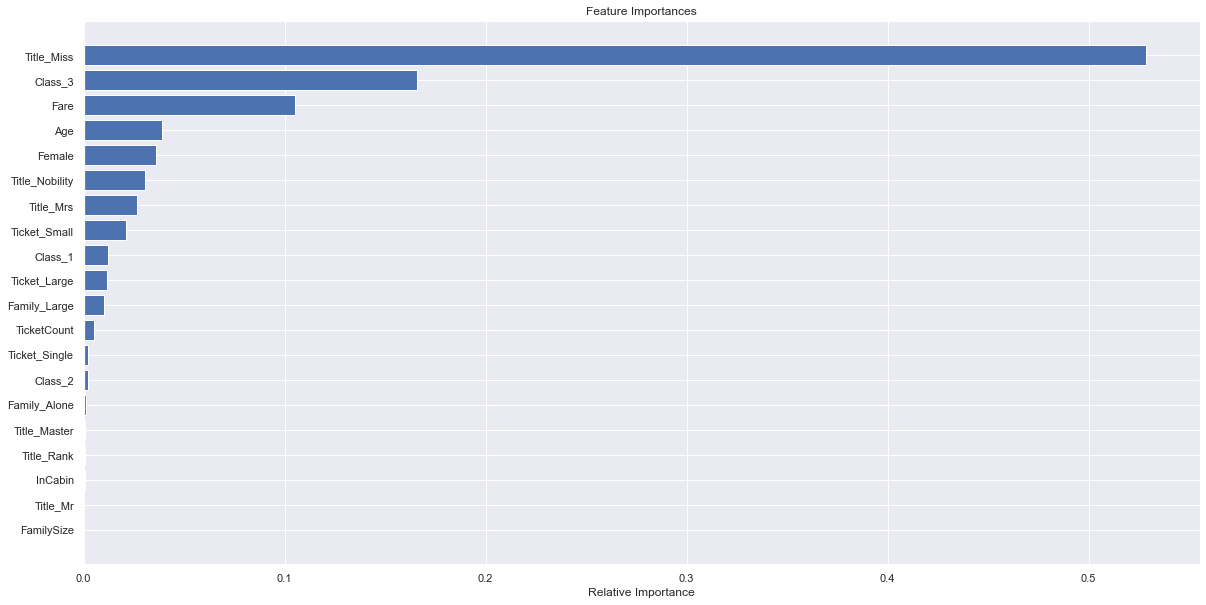

In [106]:
# Plot feature importances for baseline model
plt.rcParams["figure.figsize"] = (20,10)
plot_feature_importances(features_train, rf_grid.best_estimator_.steps[2][1])

In [107]:
rf_submission = create_submission(rf_grid.best_estimator_, features_test)

rf_submission.shape

(418, 2)

In [108]:
create_output(rf_submission, 'rf_grid.csv')